# ALGORITHME DE TRADING RENTABLE

# Notebook Modelisation

Contrairement à l'idée répandue chez les datascientists non-initiés à la finance de marché, il est assez difficile de prédire l'orientation des prix d'un actif financier... en se basant uniquement sur ses prix (Open/Close/High/Lox), ou sur des indicateurs techniques qui en dérivent.

Tout d'abord, IL est important de comprendre que les professionnels de la finance de marché ne font pas de prévision sur l'orientation des prix. Ils recherchent des patterns, c'est-à-dire des schémas, des configurations récurrentes qui offrent un avantage statistique lorsqu'ils sont utilisés un grand nombre de fois.

Ces schéma sont difficilement identifiables en analysant uniquement les prix. Les traders discrétionnaires des firms de proprietary trading utilisent des patterns qui se basent sur le temps, le prix et le volume. Les traders quantitatifs de ces mêmes firmes peuvent utiliser en plus de ce triptyque temps/prix/volume, des données quantitatives (ex: données 3 de l'order flow...), fondamentales (ex : taux d'intérêt de la FED, NFP...) et alternatives (utilisation de NLP ou de computer vision pour capturer le sentiment des investisseurs, des image sattelites...)

Dans cet exemple, nous allons créer un modèle qui utilise des données basées sur le triptyque temps/prix/volumes.
Nous allons ensuite backtester notre modèle, puis nous le mettrons en production sur un serveur AWS en utilisant une API qui permet de se connecter au futures du CME et faire du trading live. 

In [4]:
# Importer les librairies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import math
from datetime import timedelta
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import sklearn as sk
import missingno as msno 

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve, TimeSeriesSplit
from sklearn.metrics import make_scorer, classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, balanced_accuracy_score
from xgboost import XGBClassifier

import time
pd.set_option('display.max_columns', None)

# Importer le df

!pip install yfinance
import yfinance as yf
df = yf.download('QQQ',period = '60d', interval = '5m')
df.drop(['Adj Close'], axis=1, inplace=True)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Datetime,,,,,
2021-12-30 09:30:00-05:00,401.329987,402.140015,401.010010,402.127991,1610566
2021-12-30 09:35:00-05:00,402.000000,402.250000,401.769989,401.920013,729639
2021-12-30 09:40:00-05:00,401.750000,401.760010,400.750000,401.130005,1365898
2021-12-30 09:45:00-05:00,401.000000,401.589996,400.899994,401.140106,453105
2021-12-30 09:50:00-05:00,401.250000,401.790009,401.059998,401.622803,336072


Chaque ligne représente une période de 5 minutes.

Les colonnes indiquent le prix d'ouverture (au début de la période de 5min), de cloture (a la fin de cette même période), et le prix le plus élevé et le plus bas atteint lors de cette période.

Cette représentation des prix se nomme "bougie japonaise".

# 1. ANALYSE EXPLORATOIRE

In [5]:
df.shape

(4608, 5)

In [6]:
df.isna().mean()

Open      0.0
High      0.0
Low       0.0
Close     0.0
Volume    0.0
dtype: float64

In [7]:
df.describe()

,Open,High,Low,Close,Volume
count,4608.000000,4608.000000,4608.000000,4608.000000,4.608000e+03
mean,355.995715,356.452741,355.528555,355.993243,9.821518e+05
std,20.432456,20.359995,20.493482,20.424687,8.279237e+05
min,317.880005,318.230011,317.450012,317.890015,0.000000e+00
25%,342.160011,342.727509,341.510010,342.132507,5.045128e+05
50%,353.185013,353.625000,352.744995,353.205246,7.602495e+05
75%,368.750000,369.212509,368.262497,368.750275,1.167112e+06
max,403.329987,403.569885,403.089996,403.339905,1.157276e+07


Nous allons observer s'il existe des lignes ou il n'y a eu ni volume, ni mouvements de prix. Ces lignes seront supprimées.

In [8]:
# Découvre s'il y a des lignes avec 0 mouvements réalisés 
df[(df["Open"] == df["Close"]) & (df["Open"] ==  df["High"]) & (df["Open"] ==  df["Low"]) & (df["Volume"] == 0)]

,Open,High,Low,Close,Volume
Datetime,,,,,
2022-03-25 09:52:48-04:00,359.190002,359.190002,359.190002,359.190002,0


In [9]:
# Retire les lignes avec 0 mouvements réalisés 
df = df.drop(df[(df["Open"] == df["Close"]) & (df["Open"] ==  df["High"]) & (df["Open"] ==  df["Low"]) & (df["Volume"] == 0)].index)

# Vérifie qu'il ne reste aucune ligne avec 0 mouvements réalisés 
df[(df["Open"] == df["Close"]) & (df["Open"] ==  df["High"]) & (df["Open"] ==  df["Low"]) & (df["Volume"] == 0)]

,Open,High,Low,Close,Volume
Datetime,,,,,


In [10]:
# Vérifie s'il reste des lignes avec 0 volume
df[df["Volume"] == 0].index

DatetimeIndex(['2022-01-04 13:25:00-05:00'], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)

In [11]:
df = df.drop(df[df["Volume"] == 0].index)

In [12]:
# Vérifie s'il reste des lignes avec 0 volume
df[df["Volume"] == 0].index

DatetimeIndex([], dtype='datetime64[ns, America/New_York]', name='Datetime', freq=None)

In [13]:
df.shape

(4606, 5)

In [14]:
df.isna().mean()

Open      0.0
High      0.0
Low       0.0
Close     0.0
Volume    0.0
dtype: float64

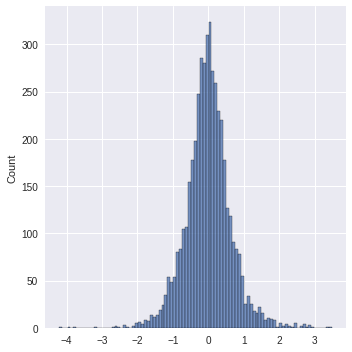

In [29]:
rendement = (df['Close']-df['Open'])
sns.displot(rendement)

Comme on pouvait s'y attendre, la distribution des rendements avec ses extremes (phénomène de long tail) est non gaussienne.

Une erreur fréquente est de vouloir normaliser les rendements. Si la transformation gaussienne peut être utile dans certains domaine, en finance elle efface la "mémoire du marché" et ne nous permet plus de détecter les patterns ayant des avantages statistiques.

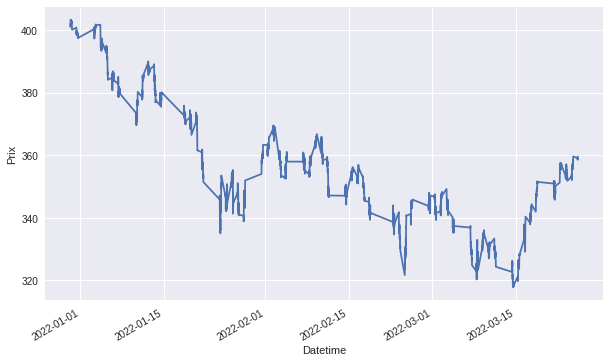

In [16]:
# Visualisation des prix de cloture
plt.figure(figsize=(10, 6))
df['Close'].plot()
plt.ylabel('Prix') 
plt.show()

Bougie haussière : 49.15 % du dataset
Bougie baisière : 50.85 % du dataset


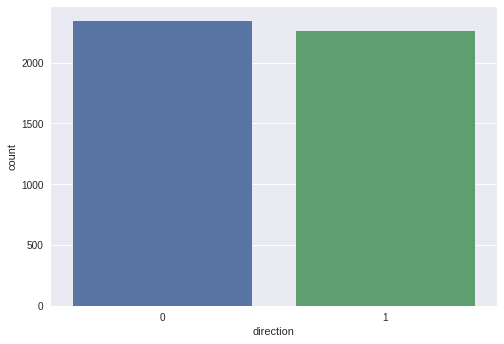

In [32]:
# Répartition des bougies haussieres(1) et baissieres(0) au sein du df 
df["direction"] = np.where((df["Close"] > df["Open"]),1,0)
sns.countplot(data=df, x="direction")

print('Bougie haussière :', round(df['direction'].value_counts()[1]/len(df) * 100,2), '% du dataset')
print('Bougie baisière :', round(df['direction'].value_counts()[0]/len(df) * 100,2), '% du dataset')

Contrairenement à ce que l'on pourrait penser en observant la tendance baissière des prix, les bougies baissières ne représente qu'une petite majorité (50.85% du dataset).

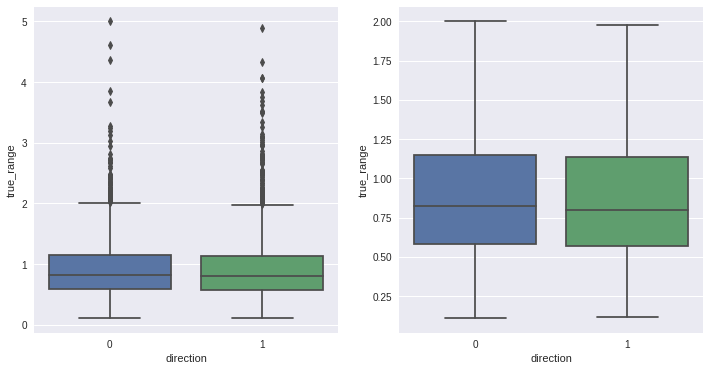

In [21]:
# Répartition des range selon la direction
plt.figure(figsize=(12, 6))
true_range = df['High'] - df['Low']

plt.subplot(1,2,1)
sns.boxplot(data=df, x='direction', y= "true_range")

plt.subplot(1,2,2)
sns.boxplot(data=df, x='direction', y= "true_range", showfliers=False)

plt.show()


Si les bougies sont équilibrées et que la tendance est baissière, cela doit donc être parce que les bougies baissieères ont une amplitude moyenne plus importante que les bougies haussières.

# 2. FEATURE SELECTION

In [33]:
# Différence/delta de prix entre la cloture et celle des x dernières bougies
df["close_diff1"] = df["Close"].diff(periods = 1)
df["close_diff2"] = df["Close"].diff(periods = 2)
df["close_diff3"] = df["Close"].diff(periods = 3)
df["close_diff4"] = df["Close"].diff(periods = 4)
df["close_diff5"] = df["Close"].diff(periods = 5)

# Ratio de vélocité ('s2 - s1' / 't2-t1') entre la close et les dernières bougies
df['veloc_1'] = df["close_diff1"] / 1
df['veloc_2'] = df["close_diff2"] / 2
df['veloc_3'] = df["close_diff3"] / 3
df['veloc_4'] = df["close_diff4"] / 4
df['veloc_5'] = df["close_diff5"] / 5

# Corps du chandelier et range 
df['body'] = (df['Close'] - df['Open'])
df['true_range'] = df['High']-df['Low']

# Corps du chandelier et range  des x dernières bougies
df['body_1'] = df['body'].shift(periods=1)
df['true_range_1'] = df['true_range'].shift(periods=1)

# Ombres basses (bougie haussiere) et ombres hautes (bougies baissières)
#df['high_shadow'] = df.apply(lambda x: x['High']-x['Close'] if x['Close']<x['Open'] else None, axis=1)
#df['low_shadow'] = df.apply(lambda x: x['Open']-x['Low'] if x['Close']>x['Open'] else None, axis=1)

# Différence entre Open Close High et Low
df["OH"] = df["Open"] - df["High"]
df["OL"] = df["Open"] - df["Low"]
df["OC"] = df["Open"] - df["Close"]
df["HL"] = df["High"] - df["Low"]
df["HC"] = df["High"] - df["Close"]
df["LC"] = df["Low"] - df["Close"]

# Différence entre Open Close High et Low et celle des x dernières bougies
df["OH_1"] = df["OH"].shift(periods=1)
df["OL_1"] = df["OL"].shift(periods=1)
df["OC_1"] = df["OC"].shift(periods=1)
df["HL_1"] = df["HL"].shift(periods=1)
df["HC_1"] = df["HC"].shift(periods=1)
df["LC_1"] = df["LC"].shift(periods=1)

## VOLUME

In [34]:
# Retire les volumes les plus bas pour créer la feature Power
#df.loc[df['Volume'] < 0.0100].count()
df.loc[df['Volume'] < 0.0100] = np.nan

# Différence de volume entre les x dernières bougies
df["vol_diff1"] = df["Volume"].diff(periods=1)
df["vol_diff2"] = df["Volume"].diff(periods=2)
df["vol_diff3"] = df["Volume"].diff(periods=3)
df["vol_diff4"] = df["Volume"].diff(periods=4)
df["vol_diff5"] = df["Volume"].diff(periods=5)

# Sma volume
df['sma7_vol'] =  df['Volume'].rolling(7).mean()
df['sma20_vol'] =  df['Volume'].rolling(20).mean()

# Power = range / Volume
df["power"] = df["Volume"] / df["true_range"]
df["power"].describe()

# Différence avec Power des x dernières bougies
df["power_1"] = df["power"].shift(periods=1)

# Retournement de tendance du volume
df['vol_rev_up'] = np.where((df['Volume'].shift(periods=1) > df['Volume'])
                            & (df['Volume'].shift(periods=1) > df['Volume'].shift(periods=2)), 1,0)
                            
df['vol_rev_down'] = np.where((df['Volume'].shift(periods=1) < df['Volume'])
                            & (df['Volume'].shift(periods=1) < df['Volume'].shift(periods=2)), 1,0)      

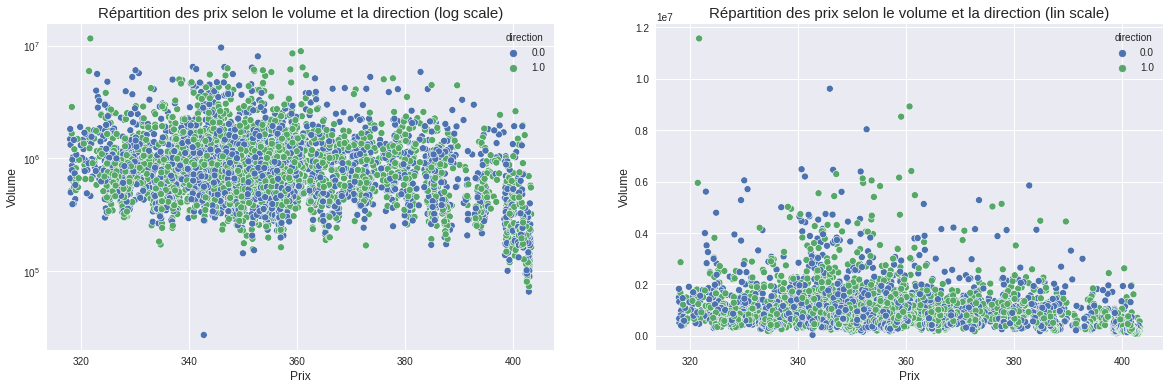

In [56]:
# Répartition des prix de cloture selon le volume et la direction des bougies
plt.figure(figsize=(20, 6))

# Echelle logaritmique
plt.subplot(1,2,1)
plt.yscale("log")
sns.scatterplot(data=df, x="Close", y="Volume", hue="direction")
plt.title("Répartition des prix selon le volume et la direction (log scale)", fontsize=15)
plt.xlabel('Prix', fontsize=12)
plt.ylabel('Volume', fontsize=12)

# Echelle linéaire
plt.subplot(1,2,2)
sns.scatterplot(data=df, x="Close", y="Volume", hue="direction")
plt.title("Répartition des prix selon le volume et la direction (lin scale)", fontsize=15)
plt.xlabel('Prix', fontsize=12)
plt.ylabel('Volume', fontsize=12)

plt.show()

## INDICATEURS TECHNIQUES

In [37]:
# Sma 
df['sma7'] =  df['Close'].rolling(7).mean()
df['sma20'] =  df['Close'].rolling(20).mean()
df['sma50'] =  df['Close'].rolling(50).mean()
df['sma200'] =  df['Close'].rolling(200).mean()

# ATR 
df['atr'] = df['true_range'].rolling(14).mean()

# Différence avec ATR des x dernières bougies
df["atr_1"] = df["atr"].shift(periods=1)

# Bande de Bollinger
def bb(data, sma, window):
    std = data.rolling(window = window).std()
    bbh = sma + std * 2
    bbb = sma - std * 2
    return bbh, bbb
df['bbh'], df['bbb'] = bb(df['Close'], df['sma20'], 20)

# Canal de Donchian 50
channel_period = 50
df['Donchian_Channel_Up'] = df['High'].rolling(channel_period).max()
df['Donchian_Channel_Down'] = df['Low'].rolling(channel_period).min()

# KST (:Know Sure Thing, "super MACD basée sur le ROC")
def get_roc(close, n): # Calcul ROC
    difference = close.diff (n) 
    nprev_values = close.shift(n) 
    roc = (difference / nprev_values) * 100 
    df['roc'] = roc
    return roc 

def get_kst(close, sma1, sma2, sma3, sma4, roc1, roc2, roc3, roc4, signal): # Calcul KST
    rcma1 = get_roc(close, roc1).rolling(sma1).mean() 
    rcma2 = get_roc(close, roc2).rolling(sma2).mean() 
    rcma3 = get_roc(close, roc3).rolling(sma3).mean() 
    rcma4 = get_roc(close, roc4).rolling(sma4).mean() 
    kst = (rcma1 * 1) + (rcma2 * 2) + (rcma3 * 3) + (rcma4 * 4)
    signal = kst.rolling(signal).mean() 
    return kst, signal 

In [41]:
# Distance entre les bandes de Bollinger (lissées par ATR)
spread_bb = df['bbh'] - df['bbb']
df['spread_bb_atr'] = spread_bb * df['atr']

# Distance entre les canaux de Donchian (lissées par ATR)
spread_donch = df['Donchian_Channel_Up'] - df['Donchian_Channel_Down']
df['spread_donch_atr'] = spread_donch * df['atr']

####################

# Distance Close- sma 
df['price_sma7'] = df['Close'] - df['sma7']
df['price_sma20'] = df['Close'] - df['sma20']
df['price_sma50'] = df['Close'] - df['sma50']
df['price_sma200'] = df['Close'] - df['sma200']

# Distance High / Low - sma
df['dist_high_sma7'] = (df['High'] - df['sma7'])
df['dist_high_sma20'] = (df['High'] - df['sma20'])
df['dist_high_sma50'] = (df['High'] - df['sma50'])
df['dist_high_sma200'] = (df['High'] - df['sma200'])

df['dist_low_sma7'] = (df['Low'] - df['sma7'])
df['dist_low_sma20'] = (df['Low'] - df['sma20'])
df['dist_low_sma50'] = (df['Low'] - df['sma50'])
df['dist_low_sma200'] = (df['Low'] - df['sma200'])

####################

# Distance Prix - bb
df['dist_close_bbh'] = df['Close'] - df['bbh']
df['dist_high_bbh'] = (df['High'] - df['bbh'])
df['dist_high_bbb'] = (df['High'] - df['bbb'])

df['dist_close_bbb'] = df['Close'] - df['bbb']
df['dist_low_bbh'] = (df['Low'] - df['bbh'])
df['dist_low_bbb'] = (df['Low'] - df['bbb'])

# Distance Prix - Donchian
df['price_donch_low'] = df['Close'] - df['Donchian_Channel_Down']
df['price_donch_up'] = df['Close'] - df['Donchian_Channel_Up']

###################

# Différence entre les sma actuelles et les sma des x precedentes périodes
sma7 = df['sma7'] = df['Close'].rolling(7).mean()
sma20 = df['sma20'] = df['Close'].rolling(20).mean()
sma50 = df['sma50'] = df['Close'].rolling(50).mean()
bbb = df['bbb']
bbh = df['bbh']

# Différence entre la sma7 et les x precedentes sma7
df["sma7_diff1"] = sma7.diff(periods = 1)
df["sma7_diff2"] = sma7.diff(periods = 2)
df["sma7_diff3"] = sma7.diff(periods = 3)
df["sma7_diff4"] = sma7.diff(periods = 4)
df["sma7_diff5"] = sma7.diff(periods = 5)

# Différence entre la sma20 et les x precedentes sma20
df["sma20_diff1"] = sma20.diff(periods = 1)
df["sma20_diff2"] = sma20.diff(periods = 2)
df["sma20_diff3"] = sma20.diff(periods = 3)
df["sma20_diff4"] = sma20.diff(periods = 4)
df["sma20_diff5"] = sma20.diff(periods = 5)

# Différence entre la sma50 et les x precedentes sma50
df["sma50_diff1"] = sma50.diff(periods = 1)
df["sma50_diff2"] = sma50.diff(periods = 2)
df["sma50_diff3"] = sma50.diff(periods = 3)
df["sma50_diff4"] = sma50.diff(periods = 4)
df["sma50_diff5"] = sma50.diff(periods = 5)

# Différence entre la bbb et les x precedentes bbb
df["bbb_diff1"] = bbb.diff(periods = 1)
df["bbb_diff2"] = bbb.diff(periods = 2)
df["bbb_diff3"] = bbb.diff(periods = 3)
df["bbb_diff4"] = bbb.diff(periods = 4)
df["bbb_diff5"] = bbb.diff(periods = 5)

# Différence entre la bbh et les x precedentes bbh
df["bbh_diff1"] = bbh.diff(periods = 1)
df["bbh_diff2"] = bbh.diff(periods = 2)
df["bbh_diff3"] = bbh.diff(periods = 3)
df["bbh_diff4"] = bbh.diff(periods = 4)
df["bbh_diff5"] = bbh.diff(periods = 5)

# Différence entre la donch up et les x precedentes donch up
df["donch_up_diff1"] = df['Donchian_Channel_Up'].diff(periods = 1)

# Différence entre la donch down et les x precedentes donch down
df["donch_down_diff1"] = df['Donchian_Channel_Down'].diff(periods = 1)

## CATEGORIE

In [44]:
#__________ Prix

# Candlstick green 
df['candle_green'] = np.where((df['Open'] < df['Close']), 1,0)

# Candlstick green 
df['candle_red'] = np.where((df['Open'] > df['Close']), 1,0)

# Doji
df['doji'] = np.where((df['Open'] == df['Close']),1,0)

####################

df['diff_green_CAT'] = pd.cut(df['close_diff1'],
                         bins=[0, 0.140015, 0.330017, 0.609985, 9999],
                         labels=["small_diff_green", "normal_diff_green", "big_diff_green", "xl_diff_green"])

# Différence des bougies baissières en features catégorielles
df['diff_red_CAT'] = pd.cut(df['close_diff1'],
                         bins=[-9999, -0.660004, -0.334991, -0.145355, 0],
                         labels=["xl_diff1_red", "big_diff_red", "normal_diff_red", "small_diff_red"])
####################

# Bougie consécutives de même couleurs
green = df['Open'] > df['Close'] #df['candle_green']
red = df['Open'] < df['Close'] #df['candle_red']


df['consecutive_green_2'] = green & green.shift(periods=1) & green.shift(periods=2)
df['consecutive_red_2'] = red & red.shift(periods=1) & red.shift(periods=2) 

df['consecutive_green_3'] = green & green.shift(periods=1) & green.shift(periods=2) & green.shift(periods=3)
df['consecutive_red_3'] = red & red.shift(periods=1) & red.shift(periods=2) & red.shift(periods=3)

df['consecutive_green_4'] = green & green.shift(periods=1) & green.shift(periods=2) & green.shift(periods=3) & green.shift(periods=4)
df['consecutive_red_4'] = red & red.shift(periods=1) & red.shift(periods=2) & red.shift(periods=3) & red.shift(periods=4)

df['consecutive_green_5'] = green & green.shift(periods=1) & green.shift(periods=2) & green.shift(periods=3) & green.shift(periods=4) & green.shift(periods=5)
df['consecutive_red_5'] = red & red.shift(periods=1) & red.shift(periods=2) & red.shift(periods=3) & red.shift(periods=4) & red.shift(periods=5)


####################

# Range des bougies en features catégorielles
df['range_CAT'] = pd.cut(df['true_range'],
                         bins=[0, 0.540100, 0.789978,  1.140015, 9999e+06],
                         labels=["small_candle", "normal_candle", "big_candle", "xl_candle"])
#__________ Volume

# Volume en features catégorielles
df['volume_CAT'] = pd.cut(df['Volume'],
                         bins=[0, 4.516728e+05, 7.118515e+05, 1.130335e+06, 99999e+06],
                         labels=["small_volume", "normal_volume", "big_volume", "xl_volume"])

####################

# Spike de volume > 2* volume précédent
df["spike_vol"] = np.where((df["Volume"] > (df["Volume"].shift(periods = 1) * 1.5)), 1, 0)

####################

# Différence de volume entre les 2 dernières bougies (haussières) en features catégorielles
df['vol_diff_green_CAT'] = pd.cut(df['vol_diff1'],
                         bins=[0, 7.487800e+04, .802700e+05, 3.671532e+05, 999e+05],
                         labels=["small_vol_diff_green", "normal_vol_diff_green", "big_vol_diff_green", "xl_vol_diff_green"])

# Différence de volume entre les 2 dernières bougies (baissières) en features catégorielles
df['vol_diff_red_CAT'] = pd.cut(df['vol_diff1'],
                         bins=[-999e+05, -3.255540e+05, -1.650140e+05, -6.870050e+04, 0],
                         labels=["xl_vol_diff_red", "big_vol_diff_red", "normal_vol_diff_red", "small_vol_diff_red"])

####################

# absorption achat(last bougie rouge + spike Volume & bougie actuelle verte)
df['absorption_up'] = np.where((df['Open'].shift(periods = 1) > df['Close'].shift(periods = 1)) 
                               & (df['spike_vol'].shift(periods = 1)) 
                               & (df['candle_green']), 1,0)

# absorption vente(last bougie verte + spike Volume & bougie actuelle rouge)
df['absorption_down'] = np.where((df['Open'].shift(periods = 1) < df['Close'].shift(periods = 1)) 
                                 & (df['spike_vol'].shift(periods = 1)) 
                                 & (df['candle_red']), 1,0)


#__________ Rebond et breakout sur indicateurs techniques

# Rebond sur Canal de Donchian
df['reversal_donch_down'] = np.where((df['Low'].shift(periods = 1) < df["Donchian_Channel_Down"].shift(periods = 1)) 
                                & (df['Close'] > df["Donchian_Channel_Down"]), 1,0)

df['reversal_donch_up'] = np.where((df['High'].shift(periods = 1) > df["Donchian_Channel_Up"].shift(periods = 1)) 
                                   & (df['Close'] < df["Donchian_Channel_Up"]), 1,0)


# Rebond sur Bande de Bollinger
df['reversal_bbb'] = np.where((df['Low'].shift(periods = 1) < df["bbb"].shift(periods = 1)) 
                                 & (df['Low'] > df["bbb"]), 1,0)

df['reversal_bbh'] = np.where((df['High'].shift(periods = 1) > df["bbh"].shift(periods = 1)) 
                                   & (df['High'] < df["bbh"]), 1,0)

___
# Breakout sur Canal de Donchian
df['break_donch_down'] = np.where((df['Open'] > df['Donchian_Channel_Down'])
                           & (df['Close'] < df['Donchian_Channel_Down']), 1,0)

df['break_donch_up'] = np.where((df['Open'] < df['Donchian_Channel_Up'])
                           & (df['Close'] > df['Donchian_Channel_Up']), 1,0)

# Breakout sur bande de bollinger
df['break_bbb'] = np.where((df['Open'] > df['bbb'])
                           & (df['Close'] < df['bbb']), 1,0)

df['break_bbh'] = np.where((df['Open'] < df['bbh'])
                           & (df['Close'] > df['bbh']), 1,0)

Text(0.5, 0, '1: pic de volume, 0: pas de pic')

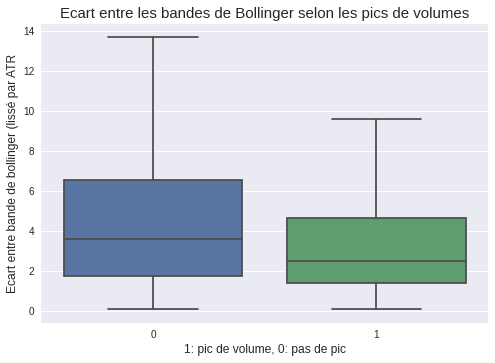

In [58]:
sns.boxplot(y="spread_bb_atr", x="spike_vol", data=df, showfliers=False)
plt.title("Ecart entre les bandes de Bollinger selon les pics de volumes", fontsize=15)
plt.ylabel("Ecart entre bande de bollinger (lissé par ATR", fontsize=12)
plt.xlabel("1: pic de volume, 0: pas de pic", fontsize=12)

On constate que les écarts entre bandes de bollingers sont beaucoup plus réduits lors des pics de volumes

In [59]:
#__________ Moyennes mobiles

# Tendance des Moyennes mobiles (sma7>sma20>sma50>200 ou inverse)
df['trend_up_sma7_20'] = np.where((df['sma7'] > df['sma20']), 1,0)
df['trend_down_sma7_20'] = np.where((df['sma7'] < df['sma20']), 1,0)

df['trend_up_sma20_50']= np.where((df['sma20'] > df['sma50']), 1,0)
df['trend_down_sma20_50'] = np.where((df['sma20'] < df['sma50']), 1,0)

df['trend_up_sma50_200']= np.where((df['sma50'] > df['sma200']), 1,0)
df['trend_down_sma50_200'] = np.where((df['sma50'] < df['sma200']), 1,0)

df['trend_up_all_sma'] = np.where((df['sma7'] > df['sma20'])
                                    & (df['sma20'] > df['sma50'])
                                    & (df['sma50'] > df['sma200']), 1,0)

df['trend_down_all_sma'] = np.where((df['sma7'] < df['sma20'])
                                    & (df['sma20'] < df['sma50'])
                                    & (df['sma50'] < df['sma200']), 1,0)
___
# Pente des moyennes mobiles (les sma montent/baissent)
df['pente_up_sma7'] = np.where((df['sma7'] > df['sma7'].shift(periods = 1)), 1,0)
df['pente_down_sma7'] = np.where((df['sma7'] < df['sma7'].shift(periods = 1)), 1,0)

df['pente_up_sma20'] = np.where((df['sma20'] > df['sma20'].shift(periods = 1)), 1,0)
df['pente_down_sma20'] = np.where((df['sma20'] < df['sma20'].shift(periods = 1)), 1,0)

df['pente_up_sma50'] = np.where((df['sma50'] > df['sma50'].shift(periods = 1)), 1,0)
df['pente_down_sma50'] = np.where((df['sma50'] < df['sma50'].shift(periods = 1)), 1,0)

df['pente_up_sma200'] = np.where((df['sma200'] > df['sma200'].shift(periods = 1)), 1,0)
df['pente_down_sma200'] = np.where((df['sma200'] < df['sma200'].shift(periods = 1)), 1,0)

df['pente_up_all_sma'] = np.where((df['sma7'] > df['sma7'].shift(periods = 1))
                                  & (df['sma20'] > df['sma20'].shift(periods = 1)) 
                                  & (df['sma50'] > df['sma50'].shift(periods = 1))
                                  & (df['sma200'] > df['sma200'].shift(periods = 1)), 1,0)

df['pente_down_all_sma'] = np.where((df['sma7'] < df['sma7'].shift(periods = 1))
                                    & (df['sma20'] < df['sma20'].shift(periods = 1)) 
                                    & (df['sma50'] < df['sma50'].shift(periods = 1))
                                    & (df['sma200'] < df['sma200'].shift(periods = 1)), 1,0)

___
# Retournement des moyennes mobiles
df['returned_sma7_up'] = np.where((df['sma7'] > df['sma7'].shift(periods=1))
                                  & (df['sma7'].shift(periods=2)>df['sma7'].shift(periods=1)), 1,0)

df['returned_sma7_down'] = np.where((df['sma7'] < df['sma7'].shift(periods=1))
                                  & (df['sma7'].shift(periods=2) < df['sma7'].shift(periods=1)), 1,0)

df['returned_sma20_up'] = np.where((df['sma20'] > df['sma20'].shift(periods=1))
                                  & (df['sma20'].shift(periods=2) > df['sma20'].shift(periods=1)), 1,0)

df['returned_sma20_down'] = np.where((df['sma20'] < df['sma20'].shift(periods=1))
                                  & (df['sma20'].shift(periods=2) < df['sma20'].shift(periods=1)), 1,0)

#__________ Bande de Bollinger

# bb s'écartent (phase 2)
df['squeeze'] = np.where((df['bbb'] < df['bbb'].shift(periods=1)) & (df['bbh'] > df['bbh'].shift(periods=1)), 1,0)

# bb se retournent (phase 3)
df['returned_bbh'] = np.where((df['bbh'].shift(periods=1) > df['bbh']) 
                            & (df['bbh'].shift(periods=1) > df['bbh'].shift(periods=2)), 1,0)

df['returned_bbb'] = np.where((df['bbb'].shift(periods=1) < df['bbb']) 
                            & (df['bbb'].shift(periods=1) < df['bbb'].shift(periods=2)), 1,0)

# bb parrallèles (phase 4)
df['parallele_up'] = np.where((df['bbb'] > df['bbb'].shift(periods=1)) 
                              & (df['bbh'] > df['bbh'].shift(periods=1)), 1,0)

df['parallele_down'] = np.where((df['bbb'] < df['bbb'].shift(periods=1)) 
                                & (df['bbh'] < df['bbh'].shift(periods=1)), 1,0) 


Text(0.5, 1.0, 'Retournement de la bande de bollinger basse selon la direction')

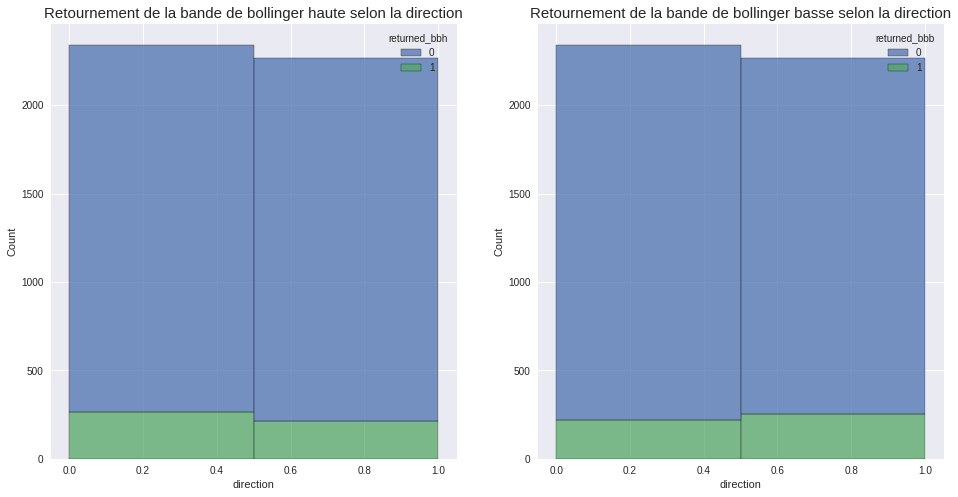

In [69]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
sns.histplot(binwidth=0.5, x="direction", hue="returned_bbh", data=df, stat="count", multiple="stack")
plt.title("Retournement de la bande de bollinger haute selon la direction", fontsize=15)

plt.subplot(1,2,2)
sns.histplot(binwidth=0.5, x="direction", hue="returned_bbb", data=df, stat="count", multiple="stack")
plt.title("Retournement de la bande de bollinger basse selon la direction", fontsize=15)


Nous avons déja constaté qu'il y a légerement plus de bougies baissiere que de bougies haussières.

Si nous pouvons constater que les retournements de la bande de bollinger haute se fontt légèrement plus souvent avec une bougie baissière, nous constatons également que les retournements de la bande de bollinger basse se font légèrement plus souvent avec une bougie haussière.


In [70]:
# Setup

# tendance sma + pente +retournement bb opposé + bougie couleur 
df['setup_buy_1'] = np.where((df['trend_down_all_sma'] & df['pente_down_all_sma'] & df['returned_bbh'] & df['candle_green']), 1,0)
df['setup_sell_1'] = np.where((df['trend_up_all_sma'] & df['pente_up_all_sma'] & df['returned_bbb'] & df['candle_red']), 1,0)

# tendance sma + pente + retournement bb même coté
df['setup_buy_2'] = np.where((df['trend_down_all_sma'] & df['pente_down_all_sma']  & df['returned_bbb']), 1,0)
df['setup_sell_2'] = np.where((df['trend_up_all_sma'] & df['pente_up_all_sma'] & df['returned_bbh']), 1,0)

# tendance sma + pente + bb parralle + retournement sma7
df['setup_buy_3'] = np.where((df['trend_down_all_sma'] & df['pente_down_all_sma']  & df['parallele_down'] & df['returned_sma7_up']), 1,0)
df['setup_sell_3'] = np.where((df['trend_up_all_sma'] & df['pente_up_all_sma'] & df['parallele_up'] & df['returned_sma7_down']), 1,0)


# TP (close > ou < sma ou high/low bbh/bbb)
df['close_sup_sma_20'] = np.where((df['Close'] >= df['sma20']), 1,0)
df['close_inf_sma_20'] = np.where((df['Close'] <= df['sma20']), 1,0)

df['high_sup_sma_20'] = np.where((df['High'] >= df['sma20']), 1,0)
df['low_inf_sma_20'] = np.where((df['Low'] <= df['sma20']), 1,0)

df['high_sup_bbh'] = np.where((df['High'] >= df['bbh']), 1,0)
df['low_inf_bbb'] = np.where((df['Low'] <= df['bbb']), 1,0)

# SL ( Close > bbh ou < bbb) ATTENTION, DOUBLON AVEC BREAKOUT
df['close_sup_bbh'] = np.where((df['Close'] >= df['bbh']), 1,0)
df['close_inf_bbb'] = np.where((df['Close'] <= df['bbb']), 1,0)

# Double bougie 
df["double_green"] = np.where((df["Close"] > df["Open"])
                             & (df["Close"].shift(periods=1) > df["Open"].shift(periods=1)), 1,0)

df["double_red"] = np.where((df["Close"] < df["Open"])
                             & (df["Close"].shift(periods=1) < df["Open"].shift(periods=1)), 1,0)
# Triple bougie
df["triple_green"] = np.where((df["Close"] > df["Open"])
                             & (df["Close"].shift(periods=1) > df["Open"].shift(periods=1))
                              & (df["Close"].shift(periods=2) > df["Open"].shift(periods=2)), 1,0)

df["triple_green"] = np.where((df["Close"] < df["Open"])
                             & (df["Close"].shift(periods=1) < df["Open"].shift(periods=1))
                              & (df["Close"].shift(periods=2) < df["Open"].shift(periods=2)), 1,0)

# Engulfing 
df['engulfing_up'] = np.where((df["Close"] > df["Open"])
                             & (df["Close"] > df["High"].shift(periods=1))
                              & (df["Low"] < df["Low"].shift(periods=1)), 1,0)

df['engulfing_down'] = np.where((df["Close"] < df["Open"])
                             & (df["Close"] < df["Low"].shift(periods=1))
                              & (df["High"] > df["High"].shift(periods=1)), 1,0)

# Inside bar
df['Inside_bar'] = np.where((df["High"] < df["High"].shift(periods=1)) 
                              & (df["Low"] > df["Low"].shift(periods=1)), 1,0)

# Break inside bar
df['breakup_inside_bar'] = np.where((df["High"].shift(periods=1) < df["High"].shift(periods=2))
                                    & (df["Low"].shift(periods=1) > df["Low"].shift(periods=2))
                                    & (df["Close"] > df["High"].shift(periods=1)), 1,0)
                                       
df['breakup_double_inside'] = np.where((df["High"].shift(periods=1) < df["High"].shift(periods=2))
                                       & (df["Low"].shift(periods=1) > df["Low"].shift(periods=2))
                                       & (df["Close"] > df["High"].shift(periods=1))
                                          & (df["Close"] > df["High"].shift(periods=2)), 1,0)
                                    
df['breakdown_inside_bar'] = np.where((df["High"].shift(periods=1) < df["High"].shift(periods=2))
                                      & (df["Low"].shift(periods=1) > df["Low"].shift(periods=2))
                                      & (df["Close"] < df["Low"].shift(periods=1)), 1,0)
                                       
df['breakdown_double_inside'] = np.where((df["High"].shift(periods=1) < df["High"].shift(periods=2))
                                         & (df["Low"].shift(periods=1) > df["Low"].shift(periods=2))
                                         & (df["Close"] < df["Low"].shift(periods=1))
                                            & (df["Close"] < df["Low"].shift(periods=2)), 1,0)                              

# 3. FEATURE ENGINEERING

In [71]:
# Affiche le taux de nan de toutes les features
pd.set_option('display.max_rows', None)
df.isna().mean()

Open                       0.000000
High                       0.000000
Low                        0.000000
Close                      0.000000
Volume                     0.000000
direction                  0.000000
close_diff1                0.000217
close_diff2                0.000434
close_diff3                0.000651
close_diff4                0.000868
close_diff5                0.001086
veloc_1                    0.000217
veloc_2                    0.000434
veloc_3                    0.000651
veloc_4                    0.000868
veloc_5                    0.001086
body                       0.000000
true_range                 0.000000
body_1                     0.000217
true_range_1               0.000217
OH                         0.000000
OL                         0.000000
OC                         0.000000
HL                         0.000000
HC                         0.000000
LC                         0.000000
OH_1                       0.000217
OL_1                       0

In [72]:
pd.set_option('display.max_rows', 10)
df.shape

(4606, 181)

In [73]:
df.head(5)

,Open,High,Low,Close,Volume,direction,close_diff1,close_diff2,close_diff3,close_diff4,close_diff5,veloc_1,veloc_2,veloc_3,veloc_4,veloc_5,body,true_range,body_1,true_range_1,OH,OL,OC,HL,HC,LC,OH_1,OL_1,OC_1,HL_1,HC_1,LC_1,vol_diff1,vol_diff2,vol_diff3,vol_diff4,vol_diff5,sma7_vol,sma20_vol,power,power_1,vol_rev_up,vol_rev_down,sma7,sma20,sma50,sma200,atr,atr_1,bbh,bbb,Donchian_Channel_Up,Donchian_Channel_Down,spread_bb_atr,spread_donch_atr,price_sma7,price_sma20,price_sma50,price_sma200,dist_high_sma7,dist_high_sma20,dist_high_sma50,dist_high_sma200,dist_low_sma7,dist_low_sma20,dist_low_sma50,dist_low_sma200,dist_close_bbh,dist_high_bbh,dist_high_bbb,dist_close_bbb,dist_low_bbh,dist_low_bbb,price_donch_low,price_donch_up,sma7_diff1,sma7_diff2,sma7_diff3,sma7_diff4,sma7_diff5,sma20_diff1,sma20_diff2,sma20_diff3,sma20_diff4,sma20_diff5,sma50_diff1,sma50_diff2,sma50_diff3,sma50_diff4,sma50_diff5,bbb_diff1,bbb_diff2,bbb_diff3,bbb_diff4,bbb_diff5,bbh_diff1,bbh_diff2,bbh_diff3,bbh_diff4,bbh_diff5,donch_up_diff1,donch_down_diff1,candle_green,candle_red,doji,diff_green_CAT,diff_red_CAT,consecutive_green_2,consecutive_red_2,consecutive_green_3,consecutive_red_3,consecutive_green_4,consecutive_red_4,consecutive_green_5,consecutive_red_5,range_CAT,volume_CAT,spike_vol,vol_diff_green_CAT,vol_diff_red_CAT,absorption_up,absorption_down,reversal_donch_down,reversal_donch_up,reversal_bbb,reversal_bbh,break_donch_down,break_donch_up,break_bbb,break_bbh,trend_up_sma7_20,trend_down_sma7_20,trend_up_sma20_50,trend_down_sma20_50,trend_up_sma50_200,trend_down_sma50_200,trend_up_all_sma,trend_down_all_sma,pente_up_sma7,pente_down_sma7,pente_up_sma20,pente_down_sma20,pente_up_sma50,pente_down_sma50,pente_up_sma200,pente_down_sma200,pente_up_all_sma,pente_down_all_sma,returned_sma7_up,returned_sma7_down,returned_sma20_up,returned_sma20_down,squeeze,returned_bbh,returned_bbb,parallele_up,parallele_down,setup_buy_1,setup_sell_1,setup_buy_2,setup_sell_2,setup_buy_3,setup_sell_3,close_sup_sma_20,close_inf_sma_20,high_sup_sma_20,low_inf_sma_20,high_sup_bbh,low_inf_bbb,close_sup_bbh,close_inf_bbb,double_green,double_red,triple_green,engulfing_up,engulfing_down,Inside_bar,breakup_inside_bar,breakup_double_inside,breakdown_inside_bar,breakdown_double_inside
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-30 09:30:00-05:00,401.329987,402.140015,401.010010,402.127991,1610566.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.798004,1.130005,NaN,NaN,-0.810028,0.319977,-0.798004,1.130005,0.012024,-1.117981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.425273e+06,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,NaN,NaN,False,False,False,False,False,False,False,False,big_candle,xl_volume,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-12-30 09:35:00-05:00,402.000000,402.250000,401.769989,401.920013,729639.0,0.0,-0.207977,NaN,NaN,NaN,NaN,-0.207977,NaN,NaN,NaN,NaN,-0.079987,0.480011,0.798004,1.130005,-0.250000,0.230011,0.079987,0.480011,0.329987,-0.150024,-0.810028,0.319977,-0.798004,1.130005,0.012024,-1.117981,-880927.0,NaN,NaN,NaN,NaN,NaN,NaN,1.520046e+06,1.425273e+06,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,NaN,normal_diff_red,False,False,False,False,False,False,False,False,small_candle,big_volume,0,NaN,xl_vol_diff_red,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [74]:
# One hot encoding des features : 'volume_CAT','range_CAT', 'diff_red_CAT', 'diff_green_CAT', 'vol_diff_green_CAT', 'vol_diff_red_CAT'

dummies = pd.get_dummies(df['volume_CAT'])
df = pd.concat([df, dummies], axis=1)

dummies2 = pd.get_dummies(df['range_CAT'])
df = pd.concat([df, dummies2], axis=1)

dummies3 = pd.get_dummies(df['diff_red_CAT'])
df = pd.concat([df, dummies3], axis=1)

dummies4 = pd.get_dummies(df['diff_green_CAT'])
df = pd.concat([df, dummies4], axis=1)

dummies5 = pd.get_dummies(df['vol_diff_green_CAT'])
df = pd.concat([df, dummies5], axis=1)

dummies6 = pd.get_dummies(df['vol_diff_red_CAT'])
df = pd.concat([df, dummies6], axis=1)
df.shape

(4606, 205)

In [75]:
df.drop(['volume_CAT','range_CAT', 'diff_red_CAT', 'diff_green_CAT', 'vol_diff_green_CAT', 'vol_diff_red_CAT'], axis=1, inplace=True)
df.shape

(4606, 199)

In [76]:
# Affiche la catégorie de chaque features
pd.set_option('display.max_rows', None)
df.dtypes

Open                       float64
High                       float64
Low                        float64
Close                      float64
Volume                     float64
direction                  float64
close_diff1                float64
close_diff2                float64
close_diff3                float64
close_diff4                float64
close_diff5                float64
veloc_1                    float64
veloc_2                    float64
veloc_3                    float64
veloc_4                    float64
veloc_5                    float64
body                       float64
true_range                 float64
body_1                     float64
true_range_1               float64
OH                         float64
OL                         float64
OC                         float64
HL                         float64
HC                         float64
LC                         float64
OH_1                       float64
OL_1                       float64
OC_1                

In [77]:
pd.set_option('display.max_rows', 10)

In [78]:
df["consecutive_green_2"] = df["consecutive_green_2"].astype(int)
df["consecutive_green_3"] = df["consecutive_green_3"].astype(int)
df["consecutive_green_4"] = df["consecutive_green_4"].astype(int)
df["consecutive_green_5"] =df["consecutive_green_5"].astype(int)

df["consecutive_red_2"] = df["consecutive_red_2"].astype(int)
df["consecutive_red_3"] = df["consecutive_red_3"].astype(int)
df["consecutive_red_4"] = df["consecutive_red_4"].astype(int)
df["consecutive_red_5"] = df["consecutive_red_5"].astype(int)

In [79]:
# Enregistre le df
df.to_csv('EDA_QQQ_5m.csv')